# Libraries

In [26]:
# IO
import os
import pathlib
from pathlib import Path
from glob import glob

# Utilities
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import random

# Import PyTorch
import torch
from torch import nn

# Import torch utilities
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import Dataset
#from torch.utils.tensorboard import SummaryWriter

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
from torchvision.io import read_image

# Visualization
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.2.2
torchvision version: 0.17.2


# GPU availability

In [2]:
torch.cuda.is_available()

True

Line required for the code to be device-agnostic

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Data preparation

## Import

I tried to make it os-agnostic, possibly messed something up

In [91]:
CodeDirectory = Path(os.path.abspath(''))
DATASET_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_data","")
DATASET_PATH = Path(DATASET_FOLDER)
BROKENDATA_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_brokenData","")
LOGGING_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_output_data","")

Loss and accuracy file

In [11]:
log_file = LOGGING_FOLDER+"log.txt"
log_file_vgg16 = LOGGING_FOLDER+"logvgg16.txt"
log_file_vgg19 = LOGGING_FOLDER+"logvgg19.txt"

## Read folder names and generate target classes

## Discard broken/not useful data

Set batch size and minimum pic dimension

In [12]:
BATCH_SIZE = 32
DIM = 256

## Data tensors

### Create data tensors

In [18]:
folder_list = glob(os.path.join(DATASET_FOLDER,"*",""), recursive = True)
subfolder_list = glob(os.path.join(DATASET_FOLDER,"*","*",""), recursive = True)
styles = [os.path.basename(os.path.normpath(x)) for x in subfolder_list]

In [63]:
len(styles)

45

Check for broken/small images and move them to a broken data folder

In [23]:
for i in range(len(subfolder_list)):
    for filename in os.listdir(subfolder_list[i]):
        image_path = str(subfolder_list[i]+filename)
        image = cv2.imread(image_path)
        # If pic is broken
        if image is None:
            os.rename(image_path, BROKENDATA_FOLDER+os.path.basename(os.path.normpath(subfolder_list[i]))+filename)
        else:
            # If pic is too small, threshold 256x256
            height, width, channels = image.shape
            if min(height,width)<DIM:
                os.rename(image_path, BROKENDATA_FOLDER+os.path.basename(os.path.normpath(subfolder_list[i]))+filename)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 'RGB ': RGB color space not permitted on grayscale PNG
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
libpng warning: iCCP: known incorrect sRGB profile


Define set of transformation, renormalizing the data and converting to b&w

In [131]:
trans_comp = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Grayscale(1) # uncomment for bw images
])

Define custom image folder class to use subfolder labels

In [199]:
def get_subsubdirectories(root_dir):
    root_path = Path(root_dir)
    return [str(d) for d in root_path.rglob('*/*/') if d.is_dir()],[d.name for d in root_path.rglob('*/*/') if d.is_dir()]

In [253]:
def list_all_files(root_dir):
    all_files = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            all_files.append(str(file_path))
    return all_files

In [271]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.classes = get_subsubdirectories(self.img_dir)[1]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.classes)

    def __getitem__(self, idx):
        img_path = list_all_files(self.img_dir)[idx]
        label = os.path.basename(os.path.normpath(Path(img_path).parent.absolute()))
        image = read_image(img_path)
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

Effectively load data applying set of transformations

In [272]:
dataset = CustomImageDataset(DATASET_FOLDER, transform=trans_comp)

### Set up training and test set

Create sets

In [282]:
train_set, test_set = torch.utils.data.random_split(dataset, [0.7, 0.3])

In [274]:
styles = dataset.classes
styles

['Gothic architecture',
 'Romanesque architecture',
 'Norman Architecture',
 'Byzantine architecture',
 'Venetian Gothic Architecture',
 'Medieval Architecture',
 'International style',
 'Chicago school architecture',
 'Bauhaus architecture',
 'Art Deco architecture',
 'Brutalism',
 'Blobitecture',
 'Neo-futurism architecture',
 'Deconstructivism',
 'Postmodern architecture',
 'Eco-architecture',
 'Tudor Revival architecture',
 'Colonial Revival archtecture',
 'Queen Anne architecture',
 'Edwardian architecture',
 'Russian Revival architecture',
 'Orientalism Architecture',
 'Ancient Egyptian architecture',
 'Herodian architecture',
 'Roman Classical architecture',
 'Achaemenid architecture',
 'Mannerist Architecture',
 'Spanish Colonial Architecture',
 'Northern Renaissance Architecture',
 'Colonial architecture',
 'Spanish Renaissance Architecture',
 'Georgian architecture',
 'French Renaissance Architecture',
 'Palladian architecture',
 'Beaux-Arts architecture',
 'Greek Revival arc

Turn datasets into iterables (batches)

In [283]:
train_loader = DataLoader(train_set, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_loader = DataLoader(test_set,
    batch_size=BATCH_SIZE,
    shuffle=True
)

Visualize the data

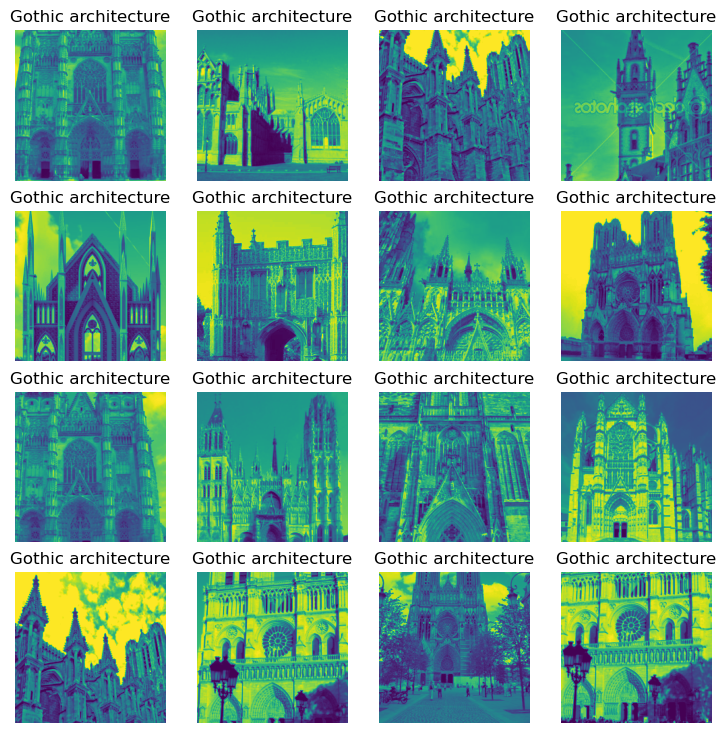

In [284]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = random.randint(0, len(train_set)-1)
    img = train_set[random_idx][0]
    label = train_set[random_idx][1]
    fig.add_subplot(rows, cols, i)
    img = img.permute(1,2,0)
    plt.imshow(img)
    plt.title(label)
    plt.axis(False);

# Model building

## ArtCoppo256

In [17]:
class ArtCoppo(nn.Module):
    def __init__(self, n_channels: int, output_shape: int):
        super().__init__()
        # input dimension 224x224
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=n_channels,
                      out_channels=6,
                      kernel_size=6, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=0),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=6,
                      out_channels=24,
                      kernel_size=13,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=7,
                         stride=5) # default stride value is same as kernel_size
            # 41x41 here
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=24,
                      out_channels=48,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=48,
                      out_channels=96,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4,
                         stride=3) # default stride value is same as kernel_size
            # 12x12 here
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=96*12*12,
                      out_features=125),
            nn.Linear(in_features=125,
                      out_features=75),
            nn.Linear(in_features=75,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

ArtCop = ArtCoppo(n_channels=1,
    output_shape=len(styles))

In [18]:
ArtCop.to(device) #send to gpu if possible

ArtCoppo(
  (block_1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(6, 6), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(6, 24, kernel_size=(13, 13), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=7, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(48, 96, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=13824, out_features=125, bias=True)
    (2): Linear(in_features=125, out_features=75, bias=True)
    (3): Linear(in_features=75, out_features=9, bias=True)
  )
)

### Training loop

In [20]:
num_classes = len(styles)
num_epochs = 30
learning_rate = 0.01


# Loss and optimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(ArtCop.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

Training data is stored in a txt file

In [26]:
# Train the model
out_txt = open(log_file,"x")

total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = ArtCop(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Logging
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        accuracy = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = ArtCop(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        # Logging
        accuracy = 100 * correct / total
        print('Accuracy of the network on the test images: {} %'.format(accuracy)) 
    out_txt.write(str(epoch)+'\t'+str(loss.item())+'\t'+str(accuracy)+'\n')

Epoch [1/30], Step [253/253], Loss: 2.1307
Accuracy of the network on the test images: 18.08203350664356 %
Epoch [2/30], Step [253/253], Loss: 2.0204
Accuracy of the network on the test images: 23.339110340843444 %
Epoch [3/30], Step [253/253], Loss: 2.0635
Accuracy of the network on the test images: 24.985557481224724 %
Epoch [4/30], Step [253/253], Loss: 1.9523
Accuracy of the network on the test images: 24.061236279607165 %
Epoch [5/30], Step [253/253], Loss: 1.6313
Accuracy of the network on the test images: 26.57423454650491 %
Epoch [6/30], Step [253/253], Loss: 1.8377
Accuracy of the network on the test images: 27.9896013864818 %
Epoch [7/30], Step [253/253], Loss: 1.9035
Accuracy of the network on the test images: 33.56441363373772 %
Epoch [8/30], Step [253/253], Loss: 2.1117
Accuracy of the network on the test images: 31.686886192952052 %
Epoch [9/30], Step [253/253], Loss: 1.9477
Accuracy of the network on the test images: 32.553437319468514 %
Epoch [10/30], Step [253/253], Lo

In [28]:
out_txt.close()

#### Save model

In [ ]:
#torch.save(vgg16, 'PATH')

### Training data plot

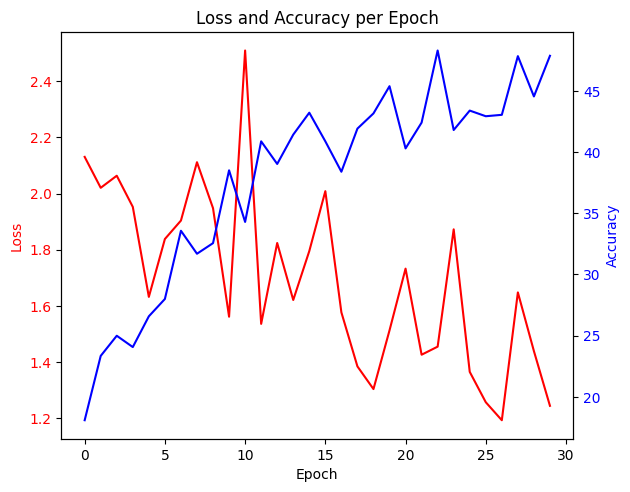

In [30]:
# Load data from the file
log_art_cop = []
with open(log_file, 'r') as file:
    for line in file:
        log_art_cop.append([float(value) for value in line.strip().split()])

# Separate data into individual lists for plotting
epochs_log = [row[0] for row in log_art_cop]
loss_log = [row[1] for row in log_art_cop]
accuracy_log = [row[2] for row in log_art_cop]

# Create the plot
fig, ax1 = plt.subplots()

# Plot the loss on the primary y-axis
ax1.plot(epochs_log, loss_log, 'r-', label='Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Create a secondary y-axis to plot accuracy
ax2 = ax1.twinx()
ax2.plot(epochs_log, accuracy_log, 'b-', label='Accuracy')
ax2.set_ylabel('Accuracy', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Add a title and show the legend
fig.tight_layout()
plt.title('Loss and Accuracy per Epoch')
plt.show()

## VGG16 (mod)

VGG16 model modified so that it takes as inputs 224x224 images

In [31]:
class VGG16(nn.Module):
    def __init__(self, num_classes=len(styles)):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), #222
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), #222
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2)) #111
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), #111
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1), #111
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) #55
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), #55
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), #55
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), #55
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) #27
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), #27
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #27
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1), #27
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) #13
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)) #6 
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(6*6*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

### Training loop

In [36]:
num_classes = len(styles)
num_epochs = 20
learning_rate = 0.01

vgg16 = VGG16(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(vgg16.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

In [ ]:
# Train the model
out_vgg_txt = open(log_file_vgg,"a")

total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Logging
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        accuracy = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = vgg16(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        # Logging
        accuracy = 100 * correct / total
        print('Accuracy of the network on the test images: {} %'.format(accuracy)) 
    out_vgg_txt.write(str(epoch)+'\t'+str(loss.item())+'\t'+str(accuracy)+'\n')

In [ ]:
out_vgg_txt.close()

#### Save model

In [ ]:
#torch.save(vgg16, 'PATH')

### Training data plot

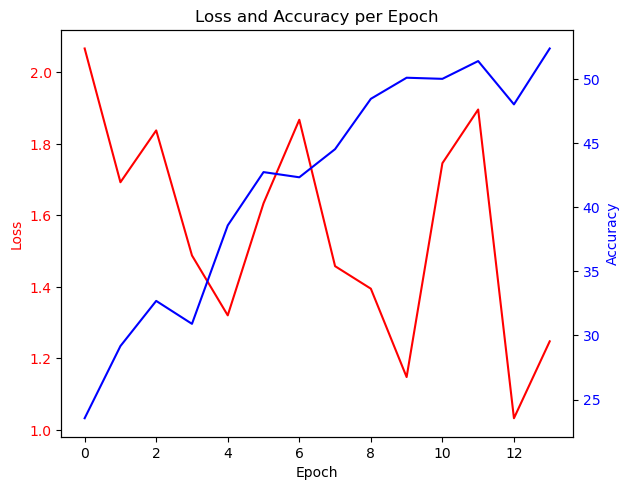

In [40]:
# Load data from the file
log_vgg = []
with open(log_file_vgg, 'r') as file:
    for line in file:
        log_vgg.append([float(value) for value in line.strip().split()])

# Separate data into individual lists for plotting
epochs_log = [row[0] for row in log_vgg]
loss_log = [row[1] for row in log_vgg]
accuracy_log = [row[2] for row in log_vgg]

# Create the plot
fig, ax1 = plt.subplots()

# Plot the loss on the primary y-axis
ax1.plot(epochs_log, loss_log, 'r-', label='Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Create a secondary y-axis to plot accuracy
ax2 = ax1.twinx()
ax2.plot(epochs_log, accuracy_log, 'b-', label='Accuracy')
ax2.set_ylabel('Accuracy', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Add a title and show the legend
fig.tight_layout()
plt.title('Loss and Accuracy per Epoch')
plt.show()

## VGG19 fine-tuning

In [5]:
vgg19 = torchvision.models.vgg19(pretrained=True)

/Users/exterior/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/exterior/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/exterior/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:47<00:00, 12.1MB/s] 


In [7]:
torch.save(vgg19.state_dict(), '/Users/exterior/Documents/IML/Project/Part2/models/vgg19.pth')